In [4]:
import numpy as np
import torch.nn as nn
import torch
import torchvision

import matplotlib.pyplot as plt
from IPython import display
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import sys

from utils import tensor_list_prod
from models import linearNN, linearNN_with_activation

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
device

'cpu'

In [283]:
def validate(loss_history, rank_history, rank_verbose_interval):
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.plot(loss_history)
        ax1.set_title('Loss')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('$||\hat{y} - y||_2$')
        ax2.plot(range(0, len(loss_history), rank_verbose_interval), rank_history)
        ax2.set_title('Rank evolution')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('rank')
        plt.show()

In [284]:
def train_nn(net, opt, loader, criterion, 
             num_epochs=500, verbose_interval=50, tol=1e-3):
    loss_history = []
    rank_history = []
    for epoch in range(num_epochs):
        for (batch, answer) in loader:
            opt.zero_grad()
            pred = net.to(device).forward(batch.to(device))
            loss = criterion(pred, answer.to(device))
            loss.backward()
            opt.step()    
        loss_history.append(loss.item())
        if epoch % verbose_interval == 0:
#             res = net.forward(x).detach().cpu().numpy()
            display.clear_output(wait=True)
            print('Epoch:', epoch)
            rank = torch.matrix_rank(tensor_list_prod(list(net.parameters())))
            rank_history.append(rank)
            validate(loss_history, rank_history, verbose_interval)
        if loss_history[-1] < tol:
            print('Early stop activated!')
            break
    return loss_history

In [285]:
num_points = 1000
d = 100
R = torch.rand(size=(d, d))
#R = (R + R.T) / 2

mu = torch.zeros(d)
sigma = torch.eye(d)

mn = MultivariateNormal(mu, sigma)

x = mn.sample((num_points,))

# x = torch.linspace(-10, 10, num_points).unsqueeze(1)
y = (x @ R).to(device)
x = x.to(device)
data = list(zip(x, y))

In [286]:
net = linearNN_with_activation(d, d, widths=[50], activation=F.relu).to(device)
opt = torch.optim.SGD(net.parameters(), lr=1e-6)
criterion = nn.MSELoss()
loader = torch.utils.data.dataloader.DataLoader(data, batch_size=300)

Epoch: 250


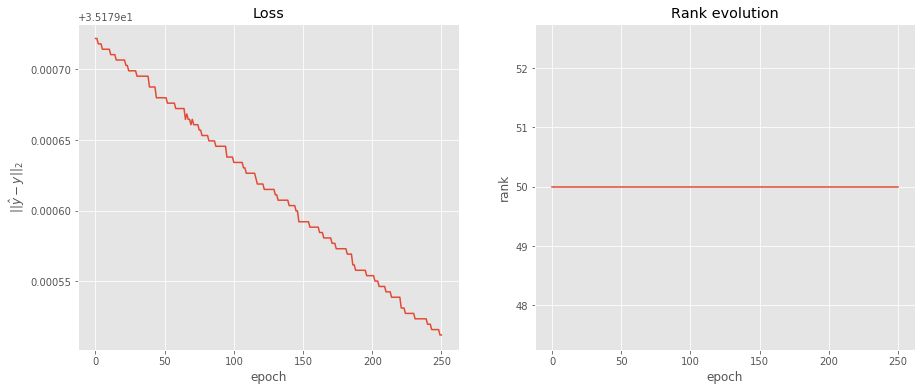

In [287]:
loss_history = train_nn(net, opt, loader, criterion, 300)